In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6),
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,target,h_target,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,...,sband_noise,sflat_std,sflat_mean,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise
count,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,...,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000,24682.000000
mean,24.931326,0.654242,71.128853,52.745193,39.420455,34.578134,32.346413,30.364749,29.263061,29.365684,...,-0.025426,-0.028692,-0.038448,-0.032883,-0.037978,15.054667,22.442087,5.093020,24.449089,4.786302
std,14.424375,0.475624,29.595103,18.646485,15.766020,14.136514,14.021414,14.207850,14.018830,13.616829,...,0.211539,0.208516,0.209806,0.207812,0.208296,11.455085,14.703956,2.946348,19.072221,3.046806
min,0.000000,0.000000,0.250354,0.261457,0.233207,0.194302,0.479011,0.404870,0.101023,0.133401,...,-0.831686,-0.719002,-0.807706,-0.724298,-0.816481,4.201246,7.270378,1.493793,4.442384,0.505268
25%,12.000000,0.000000,50.713948,41.417362,28.204012,24.003940,20.988583,17.737024,16.453377,17.087750,...,-0.176185,-0.176898,-0.189615,-0.179533,-0.184917,10.362629,15.966203,3.896846,15.948704,2.671954
50%,25.000000,1.000000,69.505743,52.956693,39.351996,35.443751,32.903715,31.852139,30.703366,30.712495,...,-0.003184,-0.012025,-0.020042,-0.014424,-0.019975,12.978106,19.181390,4.651992,19.918297,4.291419
75%,38.000000,1.000000,90.325875,64.064581,49.716627,45.029932,42.872115,41.607756,40.476601,40.253284,...,0.108959,0.105477,0.094841,0.099701,0.093823,16.767929,24.327239,5.545578,26.898541,6.256305
max,49.000000,1.000000,195.616784,151.400159,105.137463,106.834137,86.476476,78.690354,77.500602,71.848021,...,0.788496,0.825840,0.714560,0.774023,0.743058,625.681166,654.875511,121.550289,632.390268,63.727743


In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [13]:
train_X = train.drop(['target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target'], axis=1)
test_y = test['h_target']

# Shallow Net
Separate into classes

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(129,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [15]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 10,945
Trainable params: 10,945
Non-trainable params: 0
_________________________________________________________________
Train on 16783 samples, validate on 2962 samples
Epoch 1/200
16783/16783 [==============================] - 1s 40us/step - loss: 5.5304 - 

16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 53/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 54/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 55/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 56/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 57/200
16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 58/200
16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 59/200
16783/16783 [==============

Epoch 111/200
16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 112/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 113/200
16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 114/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 115/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 116/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 117/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 118/200
16783/

16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 170/200
16783/16783 [==============================] - 0s 22us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 171/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 172/200
16783/16783 [==============================] - 0s 24us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 173/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 174/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 175/200
16783/16783 [==============================] - 0s 23us/step - loss: 5.5304 - acc: 0.6531 - val_loss: 5.4092 - val_acc: 0.6607
Epoch 176/200
16783/16783 [=======

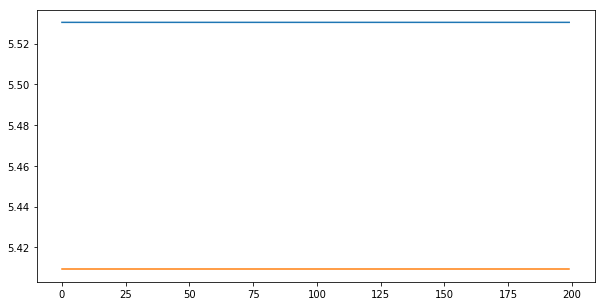

In [16]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

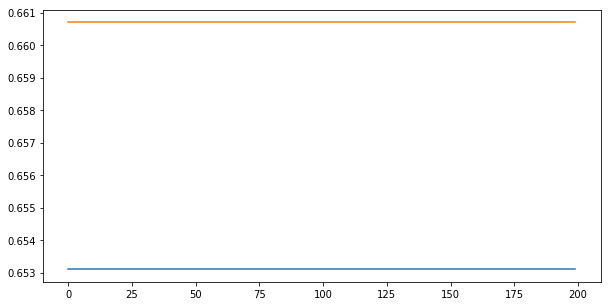

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.654243467692931
Confusion matrix, without normalization
[[   0 1707]
 [   0 3230]]


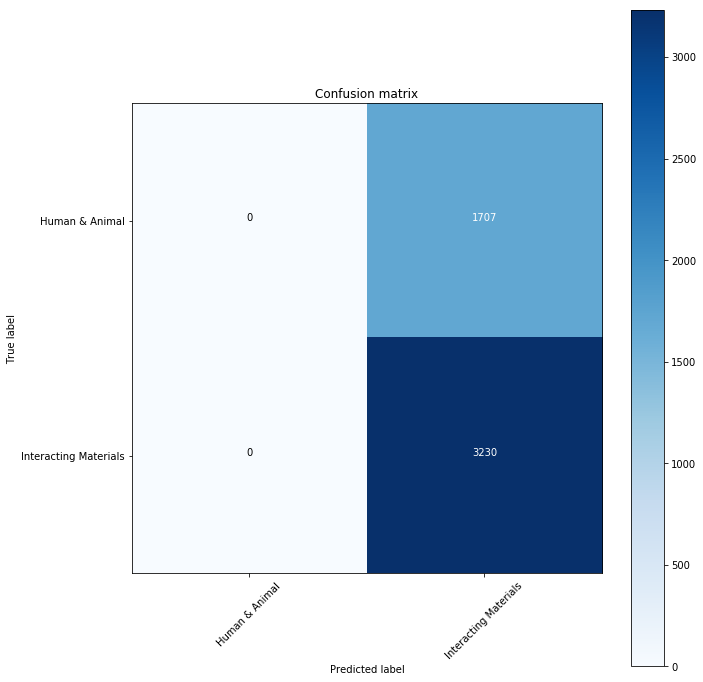

In [18]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [19]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [20]:
X = all_df.drop(['target', 'h_target'], axis=1)
y = all_df['h_target']

0.653389013813042
Confusion matrix, without normalization
[[   0 2158]
 [   0 4068]]


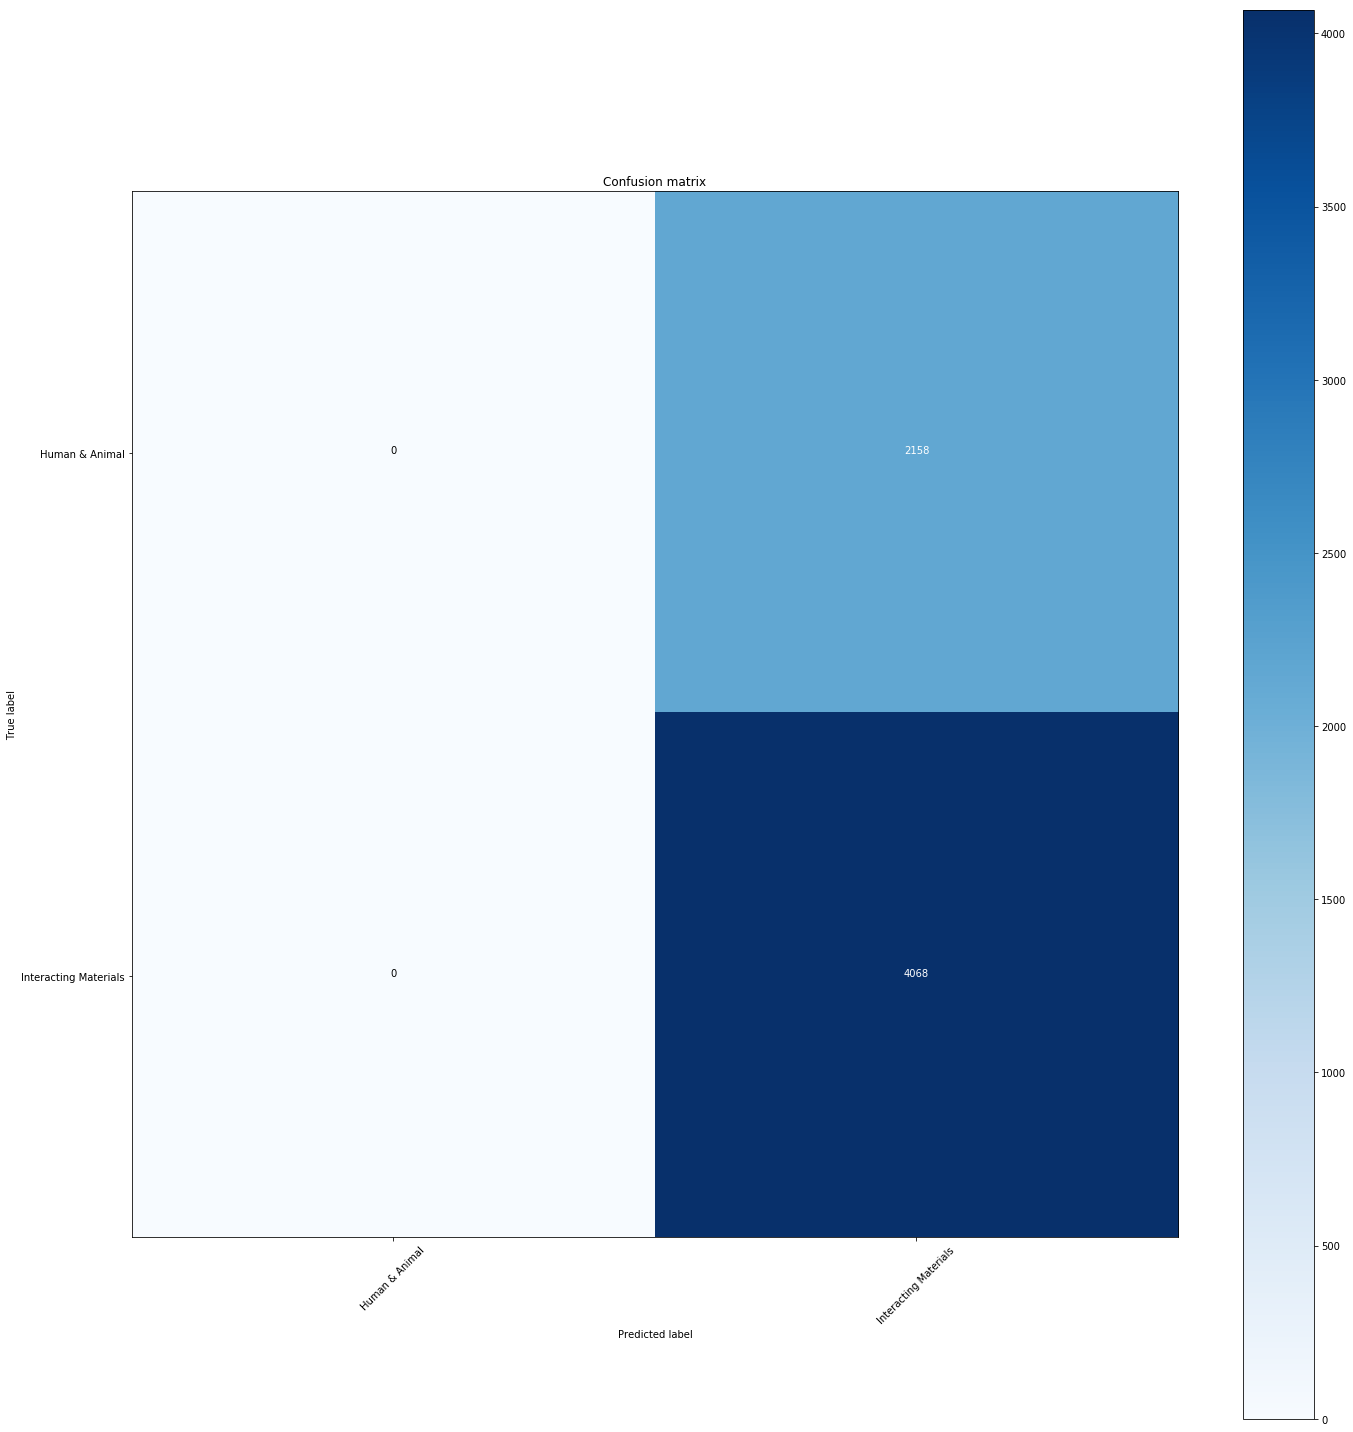

In [21]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()